#### Reference:
- https://learn.deeplearning.ai/courses/building-coding-agents-with-tool-execution/

## Overview: 
- This notebook shows how to build a Coding Agent that is a Data Analyzer.

You'll build this agent step-by-step, defining the tools it needs and implementing the agent loop that lets it reason through tasks.

You can write code by hand if you wish, but this project item includes access to a chatbot built right into the Jupyter notebook, which you can ask for help or instruct to write code for you. 

## 📚 About the Project

You'll build an agent that autonomously generates and executes code in a secure cloud sandbox to respond to user queries.

<details>
<summary><strong>Your project should include</strong></summary>

- A function that accepts a user query as input
- Tool functions with schemas that the LLM can call (like execute_code)
- Code that handles conversation memory and the **agent loop** described in the "Inside a coding agent" video
- Access to an E2B sandbox to enable safe code execution

</details>

Here's what the final product might look like:

<strong>📊 Data Analyzer Agent</strong><br/>
Generates synthetic datasets, performs statistical analysis, and creates visualizations
<br/><br/>
<img src="images/histogram.png" width="90%" style="max-height: 300px; object-fit: contain;" alt="Data Analyzer Output" />

## Your project workflow

To build your coding agent, you'll carry out the following workflow:
1. **Tool calling** 🛠️ — define tool schemas and functions to help your agent interact with files
2. **Agent loop** 🔄 — build the iterative loop that let's your agent work through your task
3. **Sandbox execution** ☁️ — give your agent access to an E2B sandbox

```

           [ Specify tools 🛠️ ]
                   |
                   v
          [ Implement agent loop 🔄 ]
                   |
                   v
        [ Set up sandbox execution ☁️ ]
```

<p><summary><strong>🗂️ Reminder: Attach context to every chatbot prompt</strong></summary>

<p>When you ask the chatbot for help, always upload these files so it has full project context:

- `<Current project notebook>.ipynb`: shares your latest code and notebook state
- `docs.md`: E2B + OpenAI documentation (linked in the next section)</p>

<p>Bringing all context keeps responses grounded in what you've built and E2B capabilities.</p>

<p>**Debugging tip:** When troubleshooting issues, share error messages and relevant code snippets with the chatbot. Follow iterative debugging practices—test small changes, verify outputs, and use the AI assistant to help diagnose problems step by step.</p>

</div>

# Step 1: 🛠️ Tool Calling

It's time to define the tools your agent can use! Every tool extends what your agent can do—from executing code to manipulating files.

- 🎯 **Goal:** Create function schemas that tell the LLM what tools are available and how to call them
- 🔁 **Workflow:** Think about what tools your agent needs (like execute_code for running Python, or write_file for creating files), then implement their schemas and execution logic
- 💡 **Remember:** Tools are called by the LLM via function calling, so schemas must be precise
- 💡 **Tip:** Use the JupyterAI chatbot with the **prompt examples below**
- 📎 **Attach these files:** `project.ipynb` and `docs.md` when asking the chatbot for help

---

## ✅ Your tool system should include:

- ✓ Function schemas that describe each tool's name, description, and parameters
- ✓ Implementation functions that execute the actual tool logic
- ✓ An executor handler that routes LLM tool calls to implementations
- ✓ Error handling for invalid tool calls or execution failures

---

<details>
<summary><strong>📚 Refresher: Function Schema Pattern (click to expand)</strong></summary>

Every tool needs three components:

1. **Schema** - JSON object describing the function signature for the LLM
2. **Implementation** - Python function that executes the tool
3. **Executor** - Handler that routes LLM tool calls to implementations

**Schema Structure:**
```python
{
    "type": "function",
    "name": "execute_code",
    "description": "Execute Python code and return result",
    "parameters": {
        "type": "object",
        "properties": {
            "code": {"type": "string", "description": "Python code"}
        },
        "required": ["code"],
        "additionalProperties": False
    }
}
```

**Why function calling?**
- Gives the LLM structured ways to interact with your system
- Ensures type safety and validation
- Enables the LLM to use tools autonomously during reasoning

</details>

<details>
<summary><strong>📚 Refresher: Tool Components (click to expand)</strong></summary>

**Implementation function:**
```python
def execute_code(code: str) -> dict:
    # Execute the code and capture output
    # Return dict with "results" and "errors" keys
    pass
```

**Executor function:**
```python
def execute_tool(name: str, args: str, tools: dict) -> dict:
    # Parse JSON args
    # Look up tool by name
    # Call tool function with args
    # Handle errors gracefully
    pass
```

**Tools dictionary:**
```python
tools = {
    "execute_code": execute_code,
    "write_file": write_file,
    # ... more tools
}
```

</details>

---

<details>
<summary><strong>📊 Prompt Example — Data Analyzer Tools (click to expand)</strong></summary>

```
You are my coding assistant. Generate Python code to define the tool calling system for my Data Analyzer Agent.
Return code only-no explanations, comments, or markdown.

Requirements:
1. Import warnings and suppress warnings with warnings.filterwarnings('ignore')
2. Import sys, StringIO, json, and Callable from typing
3. Import OpenAI from openai
4. Initialize client = OpenAI()
5. Define execute_code(code: str) -> dict function that runs code locally using exec() and captures stdout
6. Define execute_code_schema as dict with type, name, description, and parameters
7. Define tools dict mapping "execute_code" to the function
8. Define execute_tool(name: str, args: str, tools: dict) that parses JSON args and calls the tool
9. Handle errors gracefully (JSONDecodeError, KeyError, Exception) and return error messages
10. Return execution dict with "results" and "errors" keys

**Attachments:**
- `docs.md` for E2B + OpenAI documentation
- `project.ipynb` to see the progress of my project
```

</details>


In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
from io import StringIO
import json
from typing import Callable
from openai import OpenAI

client = OpenAI()

def execute_code(code: str) -> dict:
    execution = {"results": [], "errors": []}
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    try:
        exec(code)
        output = sys.stdout.getvalue()
        execution["results"].append(output)
    except Exception as e:
        execution["errors"].append(str(e))
    finally:
        sys.stdout = old_stdout
    return execution

execute_code_schema = {
    "type": "function",
    "name": "execute_code",
    "description": "Execute Python code and return the result or error.",
    "parameters": {
        "type": "object",
        "properties": {
            "code": {
                "type": "string",
                "description": "Python code to execute as a string"
            }
        },
        "required": ["code"],
        "additionalProperties": False
    }
}

tools = {
    "execute_code": execute_code
}

def execute_tool(name: str, args: str, tools: dict[str, Callable]) -> dict:
    try:
        args_dict = json.loads(args)
        if name not in tools:
            return {"error": f"Tool '{name}' not found"}
        result = tools[name](**args_dict)
        return result
    except json.JSONDecodeError as e:
        return {"error": f"Failed to parse arguments: {str(e)}"}
    except KeyError as e:
        return {"error": f"Missing argument: {str(e)}"}
    except Exception as e:
        return {"error": str(e)}

# Step 2: 🔄 Agent Loop

Now build the iterative loop that powers your coding agent! This is where the LLM reasons, calls tools, receives results, and decides what to do next.

- 🎯 **Goal:** Implement a multi-step agent that iterates until task completion or max steps
- 🔁 **Workflow:** Create a loop that alternates between LLM calls and tool execution
- 💡 **Remember:** Use max_steps to prevent infinite loops, and stop when the LLM doesn't call any functions
- 💡 **Tip:** Use the JupyterAI chatbot with the **prompt examples below**
- 📎 **Attach these files:** `project.ipynb` and `docs.md` when asking the chatbot for help

---

## ✅ Your agent loop should include:

- ✓ Message history that accumulates conversation context
- ✓ LLM API calls with developer system prompt, messages, and tool schemas
- ✓ Processing of response parts (text messages and function calls)
- ✓ Tool execution and result injection back into conversation
- ✓ Stopping conditions (max steps or no function calls)

---

<details>
<summary><strong>📚 Refresher: Agent Loop Pattern (click to expand)</strong></summary>

The agent follows this cycle:

1. **Send query** to LLM with system prompt and conversation history
2. **Process response** - check if LLM wants to call tools
3. **Execute tools** - run functions and add results to conversation
4. **Repeat** until LLM responds without tool calls or max_steps reached

**Why an agent loop?**
- Enables multi-step reasoning and tool use
- Allows the LLM to see tool results and adapt its strategy
- Prevents infinite loops with max_steps safeguard

</details>

<details>
<summary><strong>📚 Refresher: Key Components (click to expand)</strong></summary>

**Message History:**
```python
messages = [
    {"role": "user", "content": "Create a function that adds two numbers"},
    # LLM responses and tool results get appended here
]
```

**Stopping Conditions:**
- `steps >= max_steps`: Prevent infinite loops
- `not has_function_call`: LLM finished reasoning

**Function Call Result:**
```python
{
    "type": "function_call_output",
    "call_id": part.call_id,
    "output": json.dumps(result)
}
```

**Loop structure:**
```python
for step in range(max_steps):
    # 1. Call LLM
    response = client.responses.create(...)
    
    # 2. Process response parts
    for part in response.output:
        # Append to messages
        # Execute function calls
    
    # 3. Check if done
    if not has_function_call:
        break
```

</details>

---

📌 **Tip:** Test with simple queries first, then try multi-step tasks!

---

<details>
<summary><strong>📊 Prompt Example — Data Analyzer Agent Loop (click to expand)</strong></summary>

```
You are my coding assistant. Generate Python code to implement the agent loop for my Data Analyzer Agent.
Return code only-no explanations, comments, or markdown.

Requirements:
1. Define coding_agent(client: OpenAI, query: str, system: str, tools: dict, tools_schemas: list, messages: list = None, max_steps: int = 5)
2. Initialize messages list with user query if not provided
3. Create while loop that runs up to max_steps iterations
4. Call client.responses.create() with model="gpt-4.1-mini", developer role with system prompt, messages, and tools
5. Iterate over response.output parts and append to messages
6. For message parts, print the content
7. For function_call parts, execute the tool and append function_call_output to messages with call_id and JSON output
8. Track has_function_call flag and break loop if no function calls
9. Return final messages list

**Attachments:**
- `docs.md` for E2B + OpenAI documentation
- `project.ipynb` to see the progress of my project
```

</details>


In [2]:
def coding_agent(client, query, system, tools, tools_schemas, messages=None, max_steps=5):
    if messages is None:
        messages = []
    messages.append({"role": "user", "content": query})
    steps = 0
    while steps < max_steps:
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=[
                {"role": "developer", "content": system},
                *messages
            ],
            tools=tools_schemas
        )
        has_function_call = False
        for part in response.output:
            messages.append(part.to_dict())
            if part.type == "message":
                print(part.content)
            elif part.type == "function_call":
                has_function_call = True
                name = part.name
                result = execute_tool(name, part.arguments, tools)
                messages.append({
                    "type": "function_call_output",
                    "call_id": part.call_id,
                    "output": json.dumps(result)
                })
        if not has_function_call:
            break
        steps += 1
    return messages

# Step 3: ☁️ Sandbox Execution

Finally, move your agent to the cloud! Instead of running code locally, execute everything in an E2B sandbox—a secure, isolated environment perfect for untrusted code.

- 🎯 **Goal:** Integrate E2B sandbox with your coding agent for safe cloud execution
- 🔁 **Workflow:** Create sandbox, modify execute_code to use sandbox, update agent to pass sandbox to tools
- 💡 **Remember:** Sandboxes are persistent—you can reconnect, query by metadata, and serve websites from them
- 💡 **Tip:** Use the JupyterAI chatbot with the **prompt examples below**
- 📎 **Attach these files:** `project.ipynb` and `docs.md` when asking the chatbot for help

---

## ✅ Your sandbox integration should include:

- ✓ Sandbox creation with appropriate timeout
- ✓ Modified execute_code function that uses `sbx.run_code()`
- ✓ Metadata handling for images and visualizations
- ✓ Agent function updated to accept and pass sandbox parameter
- ✓ Test execution with sample query

---

<details>
<summary><strong>📚 Refresher: E2B Sandbox Features (click to expand)</strong></summary>

E2B provides secure cloud sandboxes with these capabilities:

1. **Isolated execution** - Code runs in secure microVM
2. **File system** - Create, read, write, delete files
3. **Multiple languages** - Python, JavaScript, Bash
4. **Web hosting** - Serve applications on custom ports
5. **Persistent** - Reconnect to existing sandboxes by ID

**Why use sandboxes?**
- Execute untrusted LLM-generated code safely
- Avoid polluting your local environment
- Access pre-installed packages and tools
- Serve web applications with public URLs

</details>

<details>
<summary><strong>📚 Refresher: Sandbox Integration (click to expand)</strong></summary>

**Create Sandbox:**
```python
sbx = Sandbox.create(timeout=60 * 60)  # 1 hour
```

**Execute Code:**
```python
execution = sbx.run_code("print('Hello')")
result = execution.to_json()
```

**Handle Results:**
```python
# Access stdout/stderr
print(execution.results)

# Access images (PNG data)
for result in execution.results:
    if result.png:
        # Store base64 PNG data
        png_data = result.png
```

**Modified Agent Pattern:**
```python
def coding_agent(..., sbx: Sandbox):
    # Pass sandbox to execute_tool
    result = execute_tool(name, args, tools, sbx=sbx)
```

</details>

---

📌 **Tip:** Test with a simple task first, then try complex multi-step projects!

---

<details>
<summary><strong>📊 Prompt Example — Data Analyzer Sandbox (click to expand)</strong></summary>

```
You are my coding assistant. Generate Python code to integrate E2B sandbox with my Data Analyzer Agent.
Return code only-no explanations, comments, or markdown.

Requirements:
1. Import display and Image from IPython.display, and import base64
2. Modify execute_code function to accept sbx: Sandbox parameter
3. Replace exec() with sbx.run_code(code) and capture execution object
4. Handle execution.results and execution.error
5. For results with PNG data, store in metadata dict and set result.png = None
6. Return execution.to_json() and metadata dict as tuple
7. Define execute_code_schema (same as before, LLM doesn't know about sbx parameter)
8. Update execute_tool to pass sbx=sbx kwarg to tools
9. Update coding_agent to accept sbx parameter and pass it to execute_tool
10. Create test: sbx = Sandbox.create(timeout=3600), run agent with query "Generate 50 random numbers and plot histogram"
11. After agent completes, decode and display images: for each png_data in metadata["images"], use display(Image(data=base64.b64decode(png_data))) to convert the base64 string from E2B to binary data for IPython

**Attachments:**
- `docs.md` for E2B + OpenAI documentation
- `project.ipynb` to see the progress of my project
```


[ResponseOutputText(annotations=[], text='I have generated 50 random numbers and plotted their histogram with 10 bins. The histogram shows the frequency distribution of these random numbers. If you want to see the plot or need any adjustments, please let me know!', type='output_text', logprobs=[])]


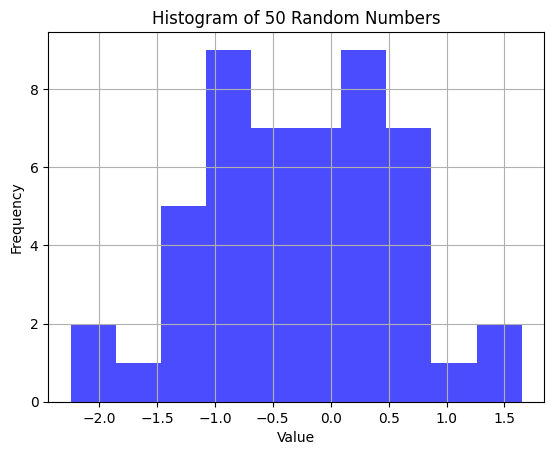

In [3]:
from IPython.display import display, Image
import base64
from e2b_code_interpreter import Sandbox
from openai import OpenAI
import json
from typing import Callable

client = OpenAI()

def execute_code(code: str, sbx: Sandbox):
    metadata = {"images": []}
    execution = sbx.run_code(code)
    if execution.results:
        for result in execution.results:
            if getattr(result, "png", None):
                metadata["images"].append(result.png)
                result.png = None
    return execution.to_json(), metadata

execute_code_schema = {
    "type": "function",
    "name": "execute_code",
    "description": "Execute Python code and return the result or error.",
    "parameters": {
        "type": "object",
        "properties": {
            "code": {
                "type": "string",
                "description": "Python code to execute as a string."
            }
        },
        "required": ["code"],
        "additionalProperties": False
    }
}

def execute_tool(name: str, args: str, tools: dict[str, Callable], sbx: Sandbox):
    try:
        args_dict = json.loads(args)
        if name not in tools:
            return {"error": f"Tool '{name}' not found"}, {}
        result, metadata = tools[name](**args_dict, sbx=sbx)
        return result, metadata
    except json.JSONDecodeError as e:
        return {"error": f"Failed to parse arguments: {str(e)}"}, {}
    except KeyError as e:
        return {"error": f"Missing argument: {str(e)}"}, {}
    except Exception as e:
        return {"error": str(e)}, {}

tools = {
    "execute_code": execute_code
}

def coding_agent(client: OpenAI, query: str, system: str, tools: dict, tools_schemas: list, sbx: Sandbox, messages: list = None, max_steps: int = 5):
    if messages is None:
        messages = []
    messages.append({"role": "user", "content": query})
    steps = 0
    metadata_total = {"images": []}
    while steps < max_steps:
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=[
                {"role": "developer", "content": system},
                *messages
            ],
            tools=tools_schemas
        )
        has_function_call = False
        for part in response.output:
            messages.append(part.to_dict())
            if part.type == "message":
                print(part.content)
            elif part.type == "function_call":
                has_function_call = True
                result, metadata = execute_tool(part.name, part.arguments, tools, sbx)
                messages.append({
                    "type": "function_call_output",
                    "call_id": part.call_id,
                    "output": json.dumps(result)
                })
                if "images" in metadata:
                    metadata_total["images"].extend(metadata["images"])
        if not has_function_call:
            break
        steps += 1
    return messages, metadata_total

sbx = Sandbox.create(timeout=3600)
system_prompt = "You are a data analysis agent. Use execute_code to run Python code for data visualization."
query = "Generate 50 random numbers and plot histogram"
messages, metadata = coding_agent(client, query, system_prompt, tools, [execute_code_schema], sbx)

for png_data in metadata["images"]:
    display(Image(data=base64.b64decode(png_data)))

---
## You've learned how to:

✅ Define tool schemas and execution functions for LLM function calling  
✅ Implement an agent loop with conversation memory and iterative reasoning  
✅ Integrate E2B sandboxes for safe cloud code execution  
✅ Handle tool results and build multi-step autonomous agents  

## Next Steps

Want to extend your project? Try:
- Adding more tools (file operations, web scraping, API calls)
- Implementing conversation memory persistence across sessions
- Creating specialized agents for different domains (data science, web dev, DevOps)
- Building multi-agent systems where agents collaborate on complex tasks

**Resources:**
- [E2B Documentation](https://e2b.dev/docs)
- [OpenAI Function Calling Guide](https://platform.openai.com/docs/guides/function-calling)
- [E2B GitHub](https://github.com/e2b-dev/e2b)